In [5]:
from typing import Sequence

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import numpy as np
from flax import linen as nn
from flax.training import train_state
import optax
import orbax.checkpoint as ocp
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection

### Mixture of Gaussians

First we're going to generate a mixture of two Gaussians that the generator is supposed to match

In [6]:
def pmf_gaussian_single(
    mu: float,
    sigma: float,
    n_pixels: int = 784,
):
    """
    Discrete Gaussian over 784 bins
    Uses probability densities at bin centres rather than 
    integrated probability masses over the bin intervals
    """
    pixel_midpoints = jnp.arange(n_pixels) + 0.5
    pixel_frequencies = jnp.exp(-0.5 * ((pixel_midpoints - mu) / sigma) ** 2)
    pixel_probabilities = pixel_frequencies / pixel_frequencies.sum()
    return pixel_probabilities

In [7]:
def pmf_gaussian_mixed(
    mu1: float,
    sigma1: float,
    mu2: float,
    sigma2: float,
    alpha: float,
    n_pixels: int = 784,
):
    """pmf for α*N(mean1, std1) + (1-α)*N(mean2, std2) on discrete bins."""
    p1 = pmf_gaussian_single(mu1, sigma1, n_pixels)
    p2 = pmf_gaussian_single(mu2, sigma2, n_pixels)
    probs = alpha * p1 + (1.0 - alpha) * p2
    return probs 

In [8]:
def r_gaussian_mixed(
    key,
    mu1: float,
    sigma1: float,
    mu2: float,
    sigma2: float,
    alpha: float,
    n_pixels: int = 784,
    n_samples: int = 100,
    n_training_samples: int = 10,
):
    """Draw histograms from the 2-Gaussian mixture.

    Returns an array of shape (n_training_samples, n_pixels), where each row
    is a histogram (normalized to sum to 1) from `n_samples` draws.
    """
    probs = pmf_gaussian_mixed(mu1, sigma1, mu2, sigma2, alpha, n_pixels)
    probs = jnp.broadcast_to(probs, (n_training_samples, n_pixels))
    counts = jr.multinomial(key, n=n_samples, p=probs)
    return counts / n_samples
    

In [9]:
class MLP(nn.Module):
    layer_sizes: Sequence[int]

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = nn.Dense(
                layer_size,
                kernel_init=nn.initializers.normal(0.1),
                bias_init=nn.initializers.normal(0.1)
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [10]:
class LowRankDense(nn.Module):
    """Low-rank dense layer implemented with two factors and einsum.

    Parameters are U in R^{in_features x rank} and V in R^{rank x features}.
    The forward pass computes y = (x @ U) @ V + b using einsum.
    """
    features: int
    rank: int
    use_bias: bool = True

    @nn.compact
    def __call__(self, inputs):
        # inputs: [batch, in_features]
        in_features = inputs.shape[-1]

        U = self.param(
            "U",
            nn.initializers.normal(0.1),
            (in_features, self.rank),
        )
        V = self.param(
            "V",
            nn.initializers.normal(0.1),
            (self.rank, self.features),
        )

        hidden = jnp.einsum("bi,ir->br", inputs, U)
        y = jnp.einsum("br,rf->bf", hidden, V)

        if self.use_bias:
            bias = self.param(
                "bias",
                nn.initializers.normal(0.1),
                (self.features,),
            )
            y = y + bias

        return y


class LowRankMLP(nn.Module):
    """
    Every layer uses the same low-rank dimension rank (="rank")
    """
    layer_sizes: Sequence[int]
    rank: int

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = LowRankDense(
                features=layer_size,
                rank=self.rank,
                use_bias=True,
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [11]:
def initialise_network_params(model, input_layer_size, key):
    """Initialize all layers for a fully-connected neural network"""
    input_shape_dummy = jnp.ones((1, input_layer_size))
    params = model.init(key, input_shape_dummy)["params"]
    return params

In [12]:
def create_training_state(layer_sizes, optimizer, key, use_lowrank: bool = False, rank: int | None = None):
    input_layer_size = layer_sizes[0]
    network_layer_sizes = layer_sizes[1:]

    if use_lowrank:
        if rank is None:
            raise ValueError("rank must be provided when use_lowrank=True")
        model = LowRankMLP(layer_sizes=network_layer_sizes, rank=rank)
    else:
        model = MLP(layer_sizes=network_layer_sizes)

    apply_fn = model.apply
    params = initialise_network_params(model, input_layer_size, key)
    training_state = train_state.TrainState.create(
        apply_fn=apply_fn,
        params=params,
        tx=optimizer,
    )
    return training_state

In [13]:
def cross_entropy_loss_single_label(logits, label):
    targets = jnp.full_like(logits, label)
    return optax.sigmoid_binary_cross_entropy(logits, targets).mean()

def generator_loss_nonsaturating(logits_real_given_fake):
    """Objective: maximise p(predicted real | fake)"""
    return + cross_entropy_loss_single_label(logits=logits_real_given_fake, label=1)

def generator_loss_saturating(logits_real_given_fake):
    """Objective: minimise p(predicted fake | fake)"""
    return - cross_entropy_loss_single_label(logits=logits_real_given_fake, label=0)

def discriminator_loss(logits_real_given_real, logits_real_given_fake):
    loss_given_real = cross_entropy_loss_single_label(logits=logits_real_given_real, label=1)
    loss_given_fake = cross_entropy_loss_single_label(logits=logits_real_given_fake, label=0)
    return (loss_given_real + loss_given_fake) / 2

In [14]:
def calculate_generator_loss(generator_params, discriminator_params, generator_apply_fn, discriminator_apply_fn, z_vector, loss_type="nonsaturating"):
    fake_images = generator_apply_fn({"params": generator_params}, z_vector)
    logits_real_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    if loss_type == "nonsaturating":
        return generator_loss_nonsaturating(logits_real_given_fake)
    elif loss_type == "saturating":
        return generator_loss_saturating(logits_real_given_fake)
    else:
        raise ValueError(f"incorrect loss type specified: {loss_type}")


def calculate_discriminator_loss(discriminator_params, generator_params, generator_apply_fn, discriminator_apply_fn, z_vector, real_images):
    fake_images = generator_apply_fn({"params": generator_params}, z_vector)
    logits_real_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    logits_real_given_real = discriminator_apply_fn({"params": discriminator_params}, real_images)
    return discriminator_loss(logits_real_given_real, logits_real_given_fake)

In [15]:
@jax.jit
def take_generator_step_nonsaturating(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        "nonsaturating",
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_generator_step_saturating(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        "saturating",
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_discriminator_step(generator, discriminator, z_vector, real_images):
    grads_by_params_fn = jax.grad(calculate_discriminator_loss)
    grads_by_params = grads_by_params_fn(
        discriminator.params,
        generator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        real_images,
    )
    return discriminator.apply_gradients(grads=grads_by_params)

In [16]:
def subsample_images_for_batch(key, images_full_sample, batch_size):
    image_ids = jax.random.randint(key, (batch_size,), 0, images_full_sample.shape[0])
    return images_full_sample[image_ids]

In [17]:
def run_training_gan(
    train_data,
    n_steps,
    generator_training_state,
    discriminator_training_state,
    key,
    steps_per_save,
    checkpoint_manager,
    batch_size: int,
    latent_dim: int,
    loss_type: str = "nonsaturating",
    start_step: int = 0,
):
    """Train a GAN using random mini-batches of real images.

    Shapes:
      - train_data["image"]: (N, n_pixels)
      - real_images_batch:   (batch_size, n_pixels)
      - z_vectors:           (batch_size, latent_dim)

    Args:
      start_step: starting global step index (for resuming from checkpoints).
    """
    real_images = train_data

    if loss_type == "nonsaturating":
        take_generator_step = take_generator_step_nonsaturating
    elif loss_type == "saturating":
        take_generator_step = take_generator_step_saturating
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

    for step in range(1, n_steps + 1):
        key, key_z_generation, key_real_subsample = jax.random.split(key, 3)

        # Random mini-batch of real images
        real_images_batch = subsample_images_for_batch(
            key_real_subsample,
            real_images,
            batch_size,
        )

        # Latent vectors for generator
        z_vectors = jax.random.normal(
            key_z_generation,
            (batch_size, latent_dim),
        )

        # Update discriminator then generator
        discriminator_training_state = take_discriminator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
            real_images_batch,
        )
        generator_training_state = take_generator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
        )

        # Monitor losses
        generator_loss_value = calculate_generator_loss(
            generator_training_state.params,
            discriminator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            loss_type=loss_type,
        )
        discriminator_loss_value = calculate_discriminator_loss(
            discriminator_training_state.params,
            generator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            real_images_batch,
        )

        global_step = start_step + step
        print(
            f"step {global_step}: generator_loss={generator_loss_value}, "
            f"discriminator_loss={discriminator_loss_value}"
        )

        if step == 1 or global_step % steps_per_save == 0:
            checkpoint_manager.save(
                global_step,
                args=ocp.args.StandardSave(
                    {
                        "generator": generator_training_state,
                        "discriminator": discriminator_training_state,
                    }
                ),
            )

    return generator_training_state, discriminator_training_state, key

In [18]:
def sample_batch(images, labels, n_batches):
    """Drops the last set of samples if they're not the right length"""
    n_samples = len(images)
    assert len(images) == len(labels)
    assert n_samples >= n_batches
    assert n_batches > 0
    n_samples_per_batch = n_samples // n_batches
    start = 0
    end = n_samples_per_batch
    while end <= n_samples: 
        yield (images[start:end], labels[start:end])
        start += n_samples_per_batch
        end += n_samples_per_batch

In [19]:
def setup_gan_training(optimizer, key, latent_dim):
    N_PIXELS = 784
    N_HIDDEN_LAYER = 128
    N_BINARY_CATEGORIES = 1

    # Generator maps from latent space (latent_dim) to image space (N_PIXELS)
    layer_sizes_generator = [latent_dim, N_HIDDEN_LAYER, N_PIXELS]
    layer_sizes_discriminator = [N_PIXELS, N_HIDDEN_LAYER, N_BINARY_CATEGORIES]

    g_key, d_key = jax.random.split(key)
    generator_training_state = create_training_state(layer_sizes_generator, optimizer, g_key)
    discriminator_training_state = create_training_state(layer_sizes_discriminator, optimizer, d_key)
    return generator_training_state, discriminator_training_state, key

In [20]:
def make_experiment_name(optimizer):
    opt_name = optimizer.__class__.__name__
    return f"gan_{opt_name}"


def make_constraints_experiment_name(optimizer, loss_type: str) -> str:
    """Experiment name for this notebook's mixture-of-Gaussians GAN runs."""
    opt_name = optimizer.__class__.__name__
    return f"gan_constraints_{opt_name}_{loss_type}"


def initialise_checkpoint_manager(experiment_name: str = "gan", max_to_keep=20):
    project_root = Path().resolve()
    base_dir = project_root / "checkpoints"
    checkpoint_dir = base_dir / experiment_name
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_manager = ocp.CheckpointManager(
        directory=str(checkpoint_dir),
        options=ocp.CheckpointManagerOptions(max_to_keep=max_to_keep),
    )
    return checkpoint_manager

In [21]:
def train_gan(
    train_data, 
    optimizer, 
    n_steps=10**3, 
    steps_per_save=100, 
    key=jax.random.key(0),
    batch_size: int = 128,
    latent_dim: int = 64,
    loss_type: str = "nonsaturating",
    ):
    experiment_name = make_constraints_experiment_name(optimizer, loss_type)
    checkpoint_manager = initialise_checkpoint_manager(experiment_name)

    generator_training_state, discriminator_training_state, key = setup_gan_training(
        optimizer=optimizer,
        key=key,
        latent_dim=latent_dim,
    )

    generator_training_state, discriminator_training_state, key = run_training_gan(
        train_data=train_data,
        n_steps=n_steps,
        generator_training_state=generator_training_state,
        discriminator_training_state=discriminator_training_state,
        key=key,
        steps_per_save=steps_per_save,
        checkpoint_manager=checkpoint_manager,
        batch_size=batch_size,
        latent_dim=latent_dim,
        loss_type=loss_type,
    )
    return generator_training_state, discriminator_training_state, key

In [22]:
# train_data = prepare_data(mnist_data["train"], subsample_size=10**4) 
# test_data = prepare_data(mnist_data["test"], subsample_size=10**3) 

In [23]:
key = jr.key(0)
n_training_samples = 10_000
n_pixels = 784
n_samples = 10_000

mu1 = 200
sigma1 = 50
mu2 = 350
sigma2 = 50 
alpha = 0.5
train_data = r_gaussian_mixed(key, mu1, sigma1, mu2, sigma2, alpha, n_pixels, n_samples, n_training_samples)

In [213]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
n_steps = 5_000
steps_per_save = 250
seed = 0
key = jax.random.key(seed)
batch_size = 128
latent_dim = 64
loss_type = "nonsaturating"

# Train GAN and save checkpoints
generator_training_state, discriminator_training_state, key = train_gan(
    train_data=train_data,
    optimizer=optimizer,
    n_steps=n_steps,
    steps_per_save=steps_per_save,
    key=key,
    batch_size=batch_size,
    latent_dim=latent_dim,
    loss_type=loss_type,
)


step 1: generator_loss=0.2309345155954361, discriminator_loss=1.3712272644042969
step 2: generator_loss=0.16097933053970337, discriminator_loss=1.5459084510803223
step 3: generator_loss=0.13246533274650574, discriminator_loss=1.6685304641723633
step 4: generator_loss=0.12622371315956116, discriminator_loss=1.7081263065338135
step 5: generator_loss=0.08316975831985474, discriminator_loss=1.870084285736084
step 6: generator_loss=0.06533394753932953, discriminator_loss=2.092430591583252
step 7: generator_loss=0.04134879261255264, discriminator_loss=2.2522802352905273
step 8: generator_loss=0.03975551575422287, discriminator_loss=2.286003351211548
step 9: generator_loss=0.055900685489177704, discriminator_loss=2.1255462169647217
step 10: generator_loss=0.05546342581510544, discriminator_loss=2.076913356781006
step 11: generator_loss=0.05941787362098694, discriminator_loss=2.036372661590576
step 12: generator_loss=0.07214837521314621, discriminator_loss=1.9659740924835205
step 13: generator

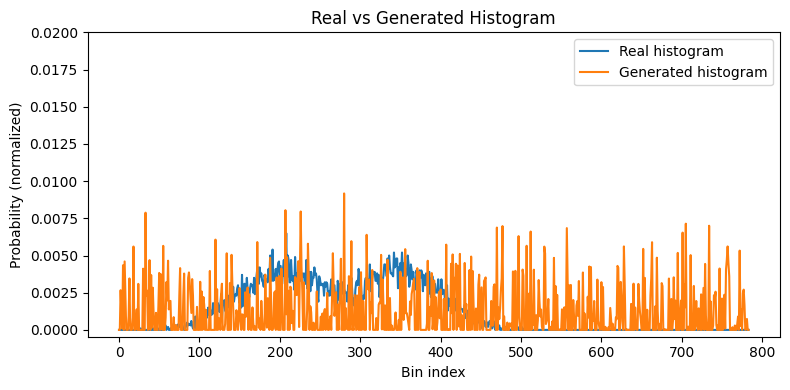

In [31]:
def plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data,
    optimizer,
    latent_dim: int,
    loss_type: str = "nonsaturating",
    y_max: float = 0.02,
):
    """Plot one real histogram and one generated histogram from last checkpoint.

    Restores the generator from the latest checkpoint for this constraints
    experiment and plots a single real vs generated histogram.
    """
    # Restore generator from the last checkpoint for this constraints experiment
    experiment_name = make_constraints_experiment_name(optimizer, loss_type)
    ckpt_manager = initialise_checkpoint_manager(experiment_name)
    steps = sorted(ckpt_manager.all_steps())
    if not steps:
        raise ValueError(
            f"No checkpoints found for experiment_name={experiment_name!r}."
        )

    # Template states for restore (we only actually use the generator here)
    gen_tmpl, disc_tmpl, _ = setup_gan_training(
        optimizer=optimizer,
        key=jax.random.key(0),
        latent_dim=latent_dim,
    )
    restored = ckpt_manager.restore(
        steps[-1],
        args=ocp.args.StandardRestore(
            item={"generator": gen_tmpl, "discriminator": disc_tmpl}
        ),
    )
    generator_for_plot = restored["generator"]

    # Local PRNG keys for this plotting run
    key = jax.random.key(0)
    key, z_key, real_key = jax.random.split(key, 3)

    # Sample a latent vector and generate one fake histogram
    z = jax.random.normal(z_key, (1, latent_dim))
    fake_hist = generator_for_plot.apply_fn(
        {"params": generator_for_plot.params},
        z,
    )[0]

    # Sample one real histogram from the training set
    real_idx = jax.random.randint(
        real_key, shape=(), minval=0, maxval=train_data.shape[0]
    )
    real_hist = train_data[real_idx]

    # Ensure both are non-negative and normalized to sum to 1
    fake_hist = jnp.maximum(fake_hist, 0.0)
    fake_hist = fake_hist / fake_hist.sum()
    real_hist = real_hist / real_hist.sum()

    # Convert to NumPy for plotting
    fake_hist_np = np.array(fake_hist)
    real_hist_np = np.array(real_hist)

    plt.figure(figsize=(8, 4))
    plt.plot(real_hist_np, label="Real histogram")
    plt.plot(fake_hist_np, label="Generated histogram")
    plt.xlabel("Bin index")
    plt.ylabel("Probability (normalized)")
    plt.ylim(top=y_max)
    plt.title("Real vs Generated Histogram")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot using the latest checkpoint available (e.g. after first 5000 steps)
plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data=train_data,
    optimizer=optimizer,
    latent_dim=latent_dim,
    loss_type=loss_type,
    y_max=0.02,
)


In [ ]:
# def run_experiment_for_loss_type(
#     loss_type: str,
#     train_data,
#     learning_rate: float = 1e-3,
#     batch_size: int = 128,
#     latent_dim: int = 64,
#     n_steps: int = 5_000,
#     steps_per_save: int = 250,
#     seed: int = 0,
# ):
#     """Train GAN and save checkpoints for a given loss_type.

#     This function returns training results; plotting is handled separately.

#     loss_type: "nonsaturating" or "saturating".
#     """
#     print(f"=== Running experiment with loss_type={loss_type} ===")

#     # Optimizer and PRNG key
#     optimizer = optax.adam(learning_rate)
#     key = jax.random.key(seed)

#     # Train GAN and save checkpoints
#     generator_training_state, discriminator_training_state, key = train_gan(
#         train_data=train_data,
#         optimizer=optimizer,
#         n_steps=n_steps,
#         steps_per_save=steps_per_save,
#         key=key,
#         batch_size=batch_size,
#         latent_dim=latent_dim,
#         loss_type=loss_type,
#     )

#     # --- Loss curves over checkpoints for this loss_type ---
#     gen_tmpl, disc_tmpl, _ = setup_gan_training(
#         optimizer,
#         key=jax.random.key(0),
#         latent_dim=latent_dim,
#     )
#     experiment_name = make_constraints_experiment_name(optimizer, loss_type)
#     ckpt_manager = initialise_checkpoint_manager(experiment_name)
#     steps = sorted(ckpt_manager.all_steps())

#     g_losses, d_losses = [], []
#     real_images = train_data["image"]

#     for step in steps:
#         restored = ckpt_manager.restore(
#             step,
#             args=ocp.args.StandardRestore(
#                 item={"generator": gen_tmpl, "discriminator": disc_tmpl}
#             ),
#         )
#         gen_state = restored["generator"]
#         disc_state = restored["discriminator"]

#         key = jax.random.key(0)
#         key, z_key = jax.random.split(key)
#         z_vectors = jax.random.normal(
#             z_key,
#             (real_images.shape[0], latent_dim),
#         )

#         g_loss = calculate_generator_loss(
#             gen_state.params,
#             disc_state.params,
#             gen_state.apply_fn,
#             disc_state.apply_fn,
#             z_vectors,
#             loss_type=loss_type,
#         )
#         d_loss = calculate_discriminator_loss(
#             disc_state.params,
#             gen_state.params,
#             gen_state.apply_fn,
#             disc_state.apply_fn,
#             z_vectors,
#             real_images,
#         )

#         g_losses.append(float(g_loss))
#         d_losses.append(float(d_loss))

#     # Collect results (plotting handled separately)
#     return {
#         "generator_state": generator_training_state,
#         "discriminator_state": discriminator_training_state,
#         "steps": steps,
#         "g_losses": g_losses,
#         "d_losses": d_losses,
#         "loss_type": loss_type,
#         "latent_dim": latent_dim,
#     }


In [ ]:
# def plot_experiment_for_loss_type(results, train_data):
#     """Plot sample images and loss dynamics for a single loss_type run.

#     Expects the dict returned by `run_experiment_for_loss_type` and the
#     corresponding `train_data` used for training.
#     """
#     loss_type = results["loss_type"]
#     generator_training_state = results["generator_state"]
#     steps = results["steps"]
#     g_losses = results["g_losses"]
#     d_losses = results["d_losses"]
#     latent_dim = results.get("latent_dim", 64)

#     # --- Plot a sample real vs fake image ---
#     key = jax.random.key(0)
#     key, z_key, real_image_key = jax.random.split(key, 3)
#     z_vector = jax.random.normal(z_key, (1, latent_dim))
#     real_idx = jax.random.randint(
#         real_image_key, shape=(), minval=0, maxval=train_data.shape[0]
#     )

#     fake_image_flat = generator_training_state.apply_fn(
#         {"params": generator_training_state.params},
#         z_vector,
#     )
#     fake_image = fake_image_flat[0].reshape(28, 28)

#     real_image_flat = train_data[real_idx]
#     real_image = real_image_flat.reshape(28, 28)

#     fig, axes = plt.subplots(1, 2, figsize=(4, 2))
#     axes[0].imshow(real_image, cmap="gray"); axes[0].set_title(f"Real ({loss_type})"); axes[0].axis("off")
#     axes[1].imshow(fake_image, cmap="gray"); axes[1].set_title(f"Fake ({loss_type})"); axes[1].axis("off")
#     plt.tight_layout(); plt.show()

#     # --- Plot loss curves over checkpoints for this loss_type ---
#     plt.figure()
#     plt.plot(steps, g_losses, label=f"generator ({loss_type})")
#     plt.plot(steps, d_losses, label=f"discriminator ({loss_type})")
#     plt.xlabel("training step")
#     plt.ylabel("loss")
#     plt.title(f"GAN losses ({loss_type})")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # --- Plot training dynamics in (g, d) loss space ---
#     g = np.array(g_losses)
#     d = np.array(d_losses)

#     fig, ax = plt.subplots(figsize=(6, 6))
#     points = np.column_stack([g, d])
#     segments = np.stack([points[:-1], points[1:]], axis=1)

#     t = np.linspace(0.0, 1.0, len(points) - 1)
#     colors = cm.coolwarm(t)

#     lc = LineCollection(segments, colors=colors, linewidths=1.5)
#     ax.add_collection(lc)

#     ax.scatter(g, d, c=t.tolist() + [1.0], cmap="coolwarm", s=8, alpha=0.7)
#     ax.scatter(g[0], d[0], color="blue", s=50, label="start")
#     ax.scatter(g[-1], d[-1], color="red", s=50, label="end")

#     ax.set_xlabel("Generator loss")
#     ax.set_ylabel("Discriminator loss")
#     ax.set_title(f"GAN training dynamics in loss space ({loss_type})")
#     ax.grid(True)
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


In [ ]:
# # Convenience: run the full experiment for both loss types

# results_by_loss_type = {}
# for lt in ["saturating", "nonsaturating"]:
#     results_by_loss_type[lt] = run_experiment_for_loss_type(
#         loss_type=lt,
#         train_data=train_data,
#         learning_rate=1e-3,
#         batch_size=128,
#         latent_dim=64,
#         n_steps=5_000,
#         steps_per_save=250,
#         seed=0,
#     )


In [ ]:
# plot_experiment_for_loss_type(results_by_loss_type["saturating"], train_data)
# plot_experiment_for_loss_type(results_by_loss_type["nonsaturating"], train_data)

In [ ]:
# from pathlib import Path
# import matplotlib.pyplot as plt

# out_dir = Path("../../lab-notes/2025-12-17_gan-nonsaturating_loss")
# out_dir.mkdir(parents=True, exist_ok=True)

# for i, num in enumerate(sorted(plt.get_fignums()), start=1):
#     fig = plt.figure(num)
#     fig.savefig(
#         out_dir / f"2025-12-17_gan-nonsaturating_loss_{i}.png",
#         dpi=200,
#         bbox_inches="tight",
#     )

In [28]:
def plot_gan_loss_trajectory_from_checkpoints(
    train_data,
    optimizer,
    batch_size: int,
    latent_dim: int,
    loss_type: str = "nonsaturating",
):
    """Reload checkpoints for this notebook's run and plot D vs G loss.

    Uses the same naming convention as `train_gan` and evaluates losses
    at each saved checkpoint on a fresh mini-batch from `train_data`.
    """
    experiment_name = make_constraints_experiment_name(optimizer, loss_type)
    ckpt_manager = initialise_checkpoint_manager(experiment_name)
    steps = sorted(ckpt_manager.all_steps())

    if not steps:
        print(f"No checkpoints found for experiment_name={experiment_name!r}.")
        return

    # Template states for restoring checkpoints
    gen_tmpl, disc_tmpl, _ = setup_gan_training(
        optimizer=optimizer,
        key=jax.random.key(0),
        latent_dim=latent_dim,
    )

    g_losses = []
    d_losses = []

    for step in steps:
        restored = ckpt_manager.restore(
            step,
            args=ocp.args.StandardRestore(
                item={"generator": gen_tmpl, "discriminator": disc_tmpl}
            ),
        )
        gen_state = restored["generator"]
        disc_state = restored["discriminator"]

        # Use a fresh key for evaluation at each checkpoint
        key_eval = jax.random.key(0)
        key_eval, key_z, key_real = jax.random.split(key_eval, 3)

        z_vectors = jax.random.normal(key_z, (batch_size, latent_dim))
        real_images_batch = subsample_images_for_batch(key_real, train_data, batch_size)

        g_loss = calculate_generator_loss(
            gen_state.params,
            disc_state.params,
            gen_state.apply_fn,
            disc_state.apply_fn,
            z_vectors,
            loss_type=loss_type,
        )
        d_loss = calculate_discriminator_loss(
            disc_state.params,
            gen_state.params,
            gen_state.apply_fn,
            disc_state.apply_fn,
            z_vectors,
            real_images_batch,
        )

        g_losses.append(float(g_loss))
        d_losses.append(float(d_loss))

    # Convert to NumPy arrays for plotting
    g = np.array(g_losses)
    d = np.array(d_losses)

    fig, ax = plt.subplots(figsize=(6, 6))
    points = np.column_stack([d, g])  # x: discriminator, y: generator

    if len(points) > 1:
        segments = np.stack([points[:-1], points[1:]], axis=1)
        t = np.linspace(0.0, 1.0, len(points) - 1)
        colors = cm.coolwarm(t)

        lc = LineCollection(segments, colors=colors, linewidths=1.5)
        ax.add_collection(lc)

    # Scatter the points (including first/last)
    ax.scatter(points[:, 0], points[:, 1], c=np.linspace(0.0, 1.0, len(points)), cmap="coolwarm", s=12, alpha=0.8)

    if len(points) > 0:
        ax.scatter(points[0, 0], points[0, 1], color="blue", s=60, label="start")
        ax.scatter(points[-1, 0], points[-1, 1], color="red", s=60, label="end")

    ax.set_xlabel("Discriminator loss")
    ax.set_ylabel("Generator loss")
    ax.set_title(f"GAN training dynamics in loss space ({loss_type})")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


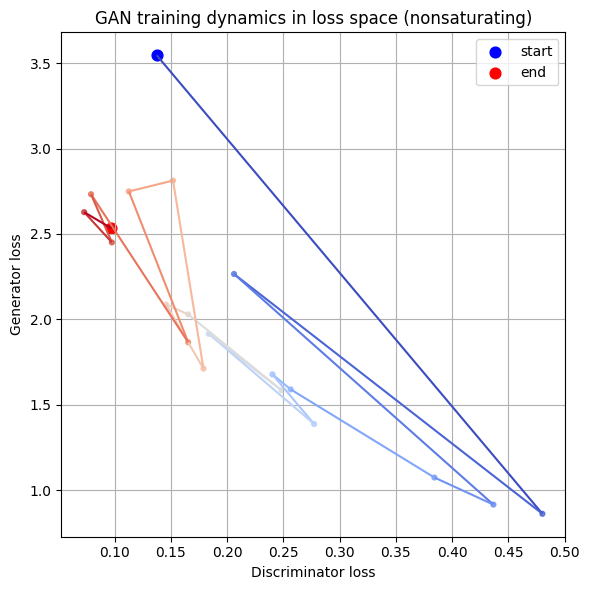

In [217]:
plot_gan_loss_trajectory_from_checkpoints(
    train_data=train_data,
    optimizer=optimizer,
    batch_size=batch_size,
    latent_dim=latent_dim,
    loss_type=loss_type,
)


Extended training

In [26]:
# Continue training from the most recent checkpoint
# Assumes only that `train_data` has already been defined.

# --- Recreate GAN / optimizer hyperparameters to match original run ---
learning_rate = 1e-3
batch_size = 128
latent_dim = 64
loss_type = "nonsaturating"
steps_per_save = 250
optimizer = optax.adam(learning_rate)

# --- Resume from last checkpoint and continue training ---
extra_steps = 5_000  # number of additional training steps
resume_seed = 1  # RNG seed for resumed training
key = jax.random.key(resume_seed)

experiment_name = make_constraints_experiment_name(optimizer, loss_type)
ckpt_manager = initialise_checkpoint_manager(experiment_name)
steps = sorted(ckpt_manager.all_steps())
if not steps:
    raise ValueError(f"No checkpoints found for experiment_name={experiment_name!r}.")

last_step = steps[-1]
print(f"Resuming training from global step {last_step} (experiment_name={experiment_name!r})")

# Template states for restoring checkpoints
gen_tmpl, disc_tmpl, _ = setup_gan_training(
    optimizer=optimizer,
    key=jax.random.key(0),
    latent_dim=latent_dim,
)
restored = ckpt_manager.restore(
    last_step,
    args=ocp.args.StandardRestore(
        item={"generator": gen_tmpl, "discriminator": disc_tmpl}
    ),
)

generator_training_state = restored["generator"]
discriminator_training_state = restored["discriminator"]

# Run additional training and keep saving checkpoints with global step indices
generator_training_state, discriminator_training_state, key = run_training_gan(
    train_data=train_data,
    n_steps=extra_steps,
    generator_training_state=generator_training_state,
    discriminator_training_state=discriminator_training_state,
    key=key,
    steps_per_save=steps_per_save,
    checkpoint_manager=ckpt_manager,
    batch_size=batch_size,
    latent_dim=latent_dim,
    loss_type=loss_type,
    start_step=last_step,
)


Resuming training from global step 5000 (experiment_name='gan_constraints_GradientTransformationExtraArgs_nonsaturating')
step 5001: generator_loss=2.4563093185424805, discriminator_loss=0.09967628121376038
step 5002: generator_loss=2.379891872406006, discriminator_loss=0.10261476039886475
step 5003: generator_loss=2.3234171867370605, discriminator_loss=0.10505685955286026
step 5004: generator_loss=2.298403739929199, discriminator_loss=0.10610902309417725
step 5005: generator_loss=2.301145553588867, discriminator_loss=0.10555579513311386
step 5006: generator_loss=2.302332878112793, discriminator_loss=0.10532952845096588
step 5007: generator_loss=2.297199249267578, discriminator_loss=0.10559152066707611
step 5008: generator_loss=2.307370901107788, discriminator_loss=0.1050216406583786
step 5009: generator_loss=2.3286795616149902, discriminator_loss=0.10418546199798584
step 5010: generator_loss=2.3299927711486816, discriminator_loss=0.10436764359474182
step 5011: generator_loss=2.3470106

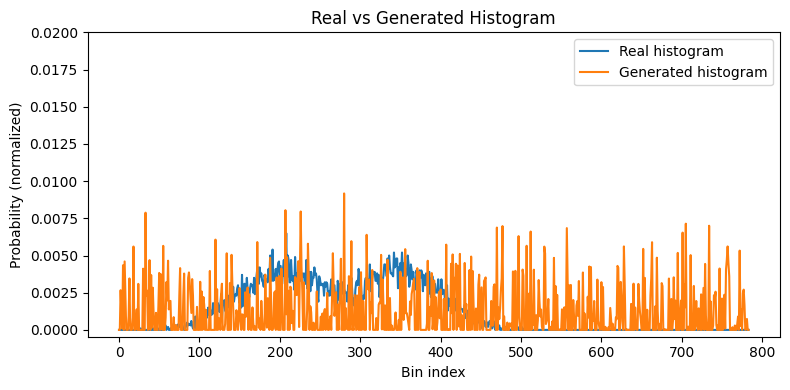

In [32]:
# Plot real vs generated histogram after extended training (up to 10,000 steps)

plot_real_vs_generated_histogram_from_last_checkpoint(
    train_data=train_data,
    optimizer=optimizer,
    latent_dim=latent_dim,
    loss_type=loss_type,
    y_max=0.02,
)


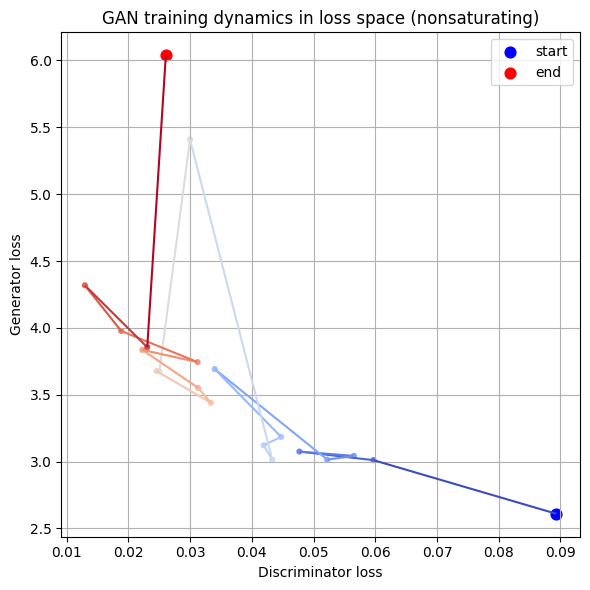

In [29]:
# Plot GAN training dynamics using all available checkpoints
# (original run + extended training)

plot_gan_loss_trajectory_from_checkpoints(
    train_data=train_data,
    optimizer=optimizer,
    batch_size=batch_size,
    latent_dim=latent_dim,
    loss_type=loss_type,
)
